<h1>Super Evil Ultra Corp</h1>

print(halo)

In [176]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [177]:
xs = np.arange(-5,5,0.25)

In [178]:
def f(x):
    return 3*x**2 -4*x +5
    

In [44]:
ys =f(xs)

In [45]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

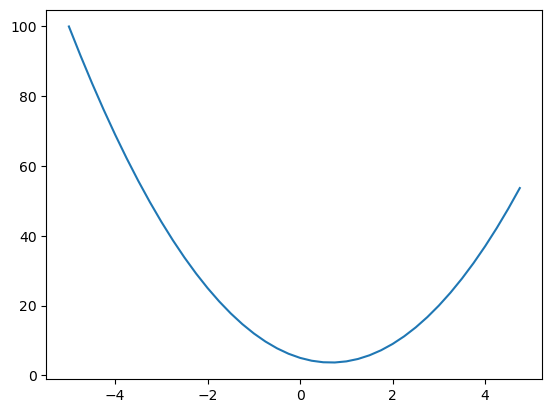

In [46]:
plt.plot(xs, ys)
plt.show()

In [179]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value data = {self.data}"
    
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other),'*')
        return out

In [180]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [181]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value (10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f= Value(-2.0, label = 'f')
L= d*f; L.label = 'L'


In [182]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [50]:
d._op

'+'

In [183]:
from graphviz import Digraph

In [184]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges



def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

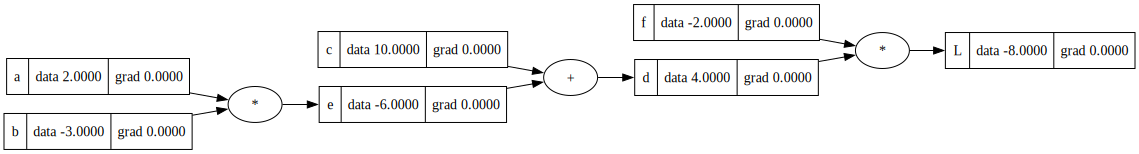

In [185]:
draw_dot(L)

In [186]:
L.grad=1.0

In [187]:
#disecting class neuron


class Neuron:
    
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        print("w= " , self.w)
        print("b= " , self.b)
        
        
    def __call__(self,x):
        z=list(zip(self.w,x))
        for i, x in z:
            return i, x 


In [188]:
#Neuron function implementation
x= [2.0, 3.0]
n = Neuron(2)
n(x)

w=  [Value(data=0.22902489627545997), Value(data=-0.20941623910228313)]
b=  Value(data=0.7763034053078639)


(Value(data=0.22902489627545997), 2.0)

In [189]:
#introducing nonlinearity in above neuron class
class Neuron:
    def __init__(self, nin):
        self.w = [Value((random.uniform(-1,1)))for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        activation = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
        out = activation.tanh()
        return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)
    
        

Value(data=-0.959566035763803)

In [199]:
	#defining layers of neurons 
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1))for _ in range(nin)]
        self.b = random.uniform(-1,1)
    def __call__(self, x):
        activation = sum((wi*xi for wi, xi in zip(self.w,x)),self.b)
        out = activation.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x ):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
            return x
    
x = [2.0, 3.0, -1.0]

n = MLP(3,[4,4,1])

n(x)

[Value(data=-0.9350330534793161),
 Value(data=-0.7697108235748228),
 Value(data=-0.41065079916872405),
 Value(data=-0.5730983954310074)]

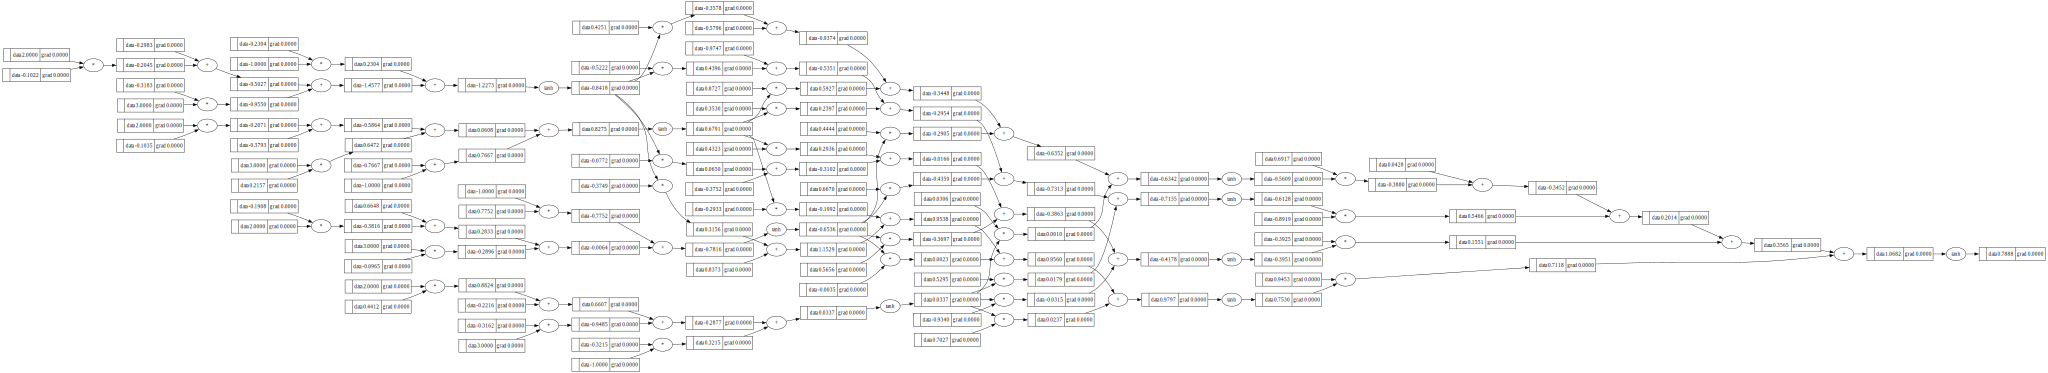

In [205]:
draw_dot(n(x))

In [202]:
# A layer of neuron design
class Neuron:
    def __init__(self, nin):
        self.w =[Value(random.uniform(-1,1)) for _ in range(nin)] 
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] +nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)


Value(data=0.7887964736847011)

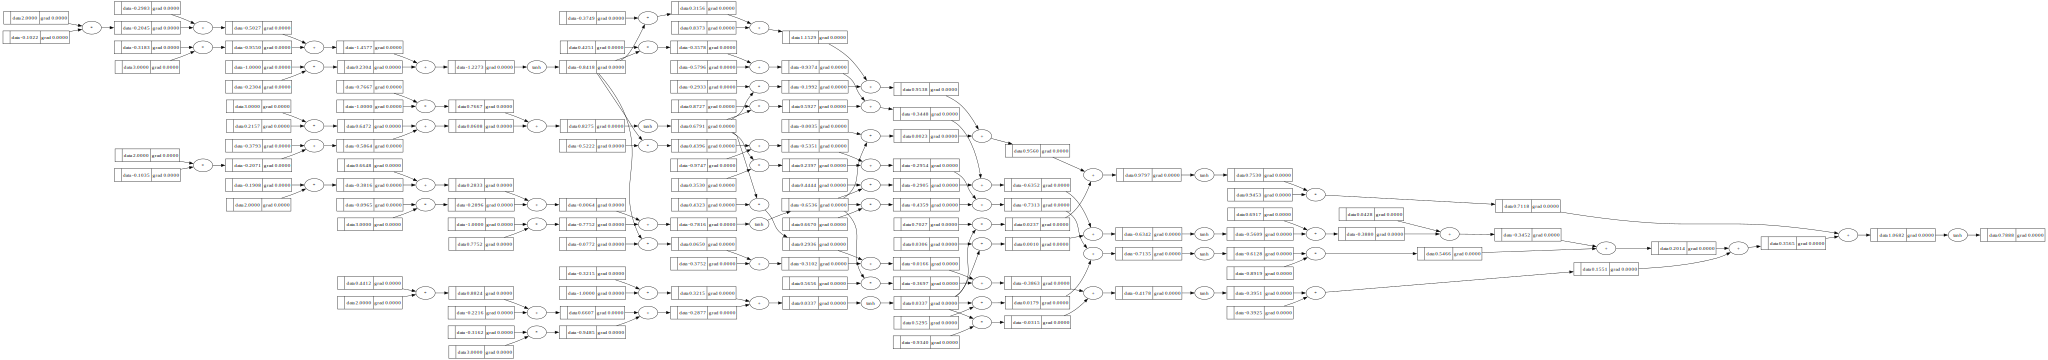

In [204]:
draw_dot(n(x))